# COVID-19 Analysis and Prediction: A Modified SEIR infectious Model

The pandemics of COVID-19 in 2020 changed the life of everyone. It is caused by a coronavirus called SARS-CoV-2. Different from most of other infectious disease, people who are infected with COVID-19 but do not exhibit symptoms can also spread the virus to others. Older adults and people who have severe underlying medical conditions like heart or lung disease or diabetes seem to be at higher risk for developing more serious complications from COVID-19 illness. As COVID-19 continues to spread across the country and the world, we should remain calm and take actions to slow down its spreading.

Here, we modified the SEIR model to accounts for the different infection feature of COVID-19 and the "lockdown" rules applied to most places. We studied three of the most serious countries: US, Italy, and France. This model fits the infection ratio and recover ratio very well.

I am keep working on this notebook and learning from the community. If you have any comments or questions, I'm happy to hear and answer.


# Import packages

In [1]:
# Algebra
import numpy as np

# Dataframe
import pandas as pd

# Missing Analysis
import missingno as msno

# Modelling
from scipy import integrate
from scipy import optimize

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Map
import folium

# Datetime
from datetime import datetime

# Import datasets

Date source:
COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University ([GitHub link](https://github.com/CSSEGISandData/COVID-19))

In [2]:
# Global cases
global_confirm_csv = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
global_death_csv = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
global_recover_csv = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
# US cases
us_confirm_csv = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
us_death_csv = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
us_state_loc_csv = 'https://gist.githubusercontent.com/mbostock/9535021/raw/eaed7e5632735a6609f02d0ba0e55c031e14200d/us-state-capitals.csv'

In [48]:
Confirmed = pd.read_csv(global_confirm_csv)
Death = pd.read_csv(global_death_csv) 
Recovered = pd.read_csv(global_recover_csv)
Confirmed_us = pd.read_csv(us_confirm_csv)
Death_us = pd.read_csv(us_death_csv)
us_state_location = pd.read_csv(us_state_loc_csv)

# Data cleaning

Settings to show the full dataset when print()

In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Global cases

remove unnecessary columns

In [49]:
# Global cases
Confirmed.drop(axis=1, inplace=True, columns=['Province/State', 'Lat', 'Long'])
Death.drop(axis=1, inplace=True, columns=['Province/State', 'Lat', 'Long'])
Recovered.drop(axis=1, inplace=True, columns=['Province/State', 'Lat', 'Long'])

In [7]:
display(Confirmed)

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20
0,Afghanistan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996,1026,1092,1176,1279,1351,1463,1531,1703,1828,1939,2171,2335,2469,2704,2894,3224,3392,3563,3778,4033,4402,4687,4963,5226,5639,6053,6402,6664,7072,7653,8145,8676,9216,9998,10582,11173,11831,12456,13036,13659,14525,15205,15750,16509,17267,18054,18969,19551,20342,20917,21459,22142,22890,23546,24102,24766,25527,26310,26874,27532,27878,28424,28833,29157,29481,29640,30175,30451,30616,30967,31238,31517,31836,32022,32324,32672,32951,33190,33384,33594,33908,34194,34366
1,Albania,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539,548,562,584,609,634,663,678,712,726,736,750,766,773,782,789,795,803,820,832,842,850,856,868,872,876,880,898,916,933,946,948,949,964,969,981,989,998,1004,1029,1050,1076,1099,1122,1137,1143,1164,1184,1197,1212,1232,1246,1263,1299,1341,1385,1416,1464,1521,1590,1672,1722,1788,1838,1891,1962,1995,2047,2114,2192,2269,2330,2402,2466,2535,2580,2662,2752,2819,2893,2964,3038,3106,3188,3278,3371
2,Algeria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910,3007,3127,3256,3382,3517,3649,3848,4006,4154,4295,4474,4648,4838,4997,5182,5369,5558,5723,5891,6067,6253,6442,6629,6821,7019,7201,7377,7542,7728,7918,8113,8306,8503,8697,8857,8997,9134,9267,9394,9513,9626,9733,9831,9935,10050,10154,10265,10382,10484,10589,10698,10810,10919,11031,11147,11268,11385,11504,11631,11771,11920,12076,12248,12445,12685,12968,13273,13571,13907,14272,14657,15070,15500,15941,16404,16879,17348,17808,18242,18712
3,Andorra,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696,704,713,717,717,723,723,731,738,738,743,743,743,745,745,747,748,750,751,751,752,752,754,755,755,758,760,761,761,761,761,761,761,762,762,762,762,762,763,763,763,763,764,764,764,765,844,851,852,852,852,852,852,852,852,852,853,853,853,853,854,854,855,855,855,855,855,855,855,855,855,855,855,855,855,855,855,855,855,855,855,855,855,855,

In [58]:
# function to extract the data of different cases in different country
def extract_national_data(df, country, case):
    df_extract = df[df['Country/Region'] == country].sum(axis=0)
    df_extract = df_extract.T.reset_index()
    df_extract = df_extract.iloc[1:]
    df_extract.columns = ['date', case]
    df_extract.date = pd.to_datetime(df_extract.date)
    return df_extract

In [51]:
# function to join three types of cases in one country
def join_national_data(confirmed, death, recovered):
    total_case = confirmed.join(death.set_index('date'), on='date').join(recovered.set_index('date'), on='date')
    total_case.reset_index(inplace=True, drop=True)
    return total_case

### US

In [59]:
us_confirmed = extract_national_data(Confirmed, 'US', 'positive')
us_death = extract_national_data(Death, 'US', 'death')
us_recovered = extract_national_data(Recover, 'US', 'recovered')

In [60]:
us_status = join_national_data(us_confirmed, us_death, us_recovered)

In [61]:
display(us_status.head())

,date,positive,death,recovered
0,2020-01-22,1,0,0
1,2020-01-23,1,0,0
2,2020-01-24,2,0,0
3,2020-01-25,2,0,0
4,2020-01-26,5,0,0


### Italy

In [62]:
itl_confirmed = extract_national_data(Confirmed, 'Italy', 'positive')
itl_death = extract_national_data(Death, 'Italy', 'death')
itl_recovered = extract_national_data(Recovered, 'Italy', 'recovered')

In [63]:
itl_status = join_national_data(itl_confirmed, itl_death, itl_recovered)

In [64]:
display(itl_status.head())

,date,positive,death,recovered
0,2020-01-22,0,0,0
1,2020-01-23,0,0,0
2,2020-01-24,0,0,0
3,2020-01-25,0,0,0
4,2020-01-26,0,0,0


### France

In [65]:
frc_confirmed = extract_national_data(Confirmed, 'France', 'positive')
frc_death = extract_national_data(Death, 'France', 'death')
frc_recovered = extract_national_data(Recovered, 'France', 'recovered')

In [66]:
frc_status = join_national_data(frc_confirmed, frc_death, frc_recovered)

In [67]:
display(frc_status.head())

,date,positive,death,recovered
0,2020-01-22,0,0,0
1,2020-01-23,0,0,0
2,2020-01-24,2,0,0
3,2020-01-25,3,0,0
4,2020-01-26,3,0,0


## US national cases in states

In [ ]:
# map
us_state_loc.drop(axis=1, inplace=True, columns=['description'])
us_state_loc = us_state_loc.rename(columns={'name': 'State'})

In [ ]:
# state-wise death cases dataset
Death_us_state.drop(axis=1, inplace=True, columns=['Lat', 'Long_', 'UID', 'iso2','iso3', 'code3', 'FIPS', 'Country_Region', 'Combined_Key'])
Death_us_state = Death_us_state.groupby('Province_State').sum()
Death_us_state.reset_index(inplace=True)
Death_us_state = Death_us_state.rename(columns={"Province_State": 'State'})
us_state_death = Death_us_state.join(us_state_loc.set_index('State'), on='State')
us_state_death = us_state_death.dropna()
state_pop = us_state_death.loc[:, ['State','Population']]

# state-wise confirmed cases dataset
Confirmed_us_state.drop(axis=1, inplace=True, columns=['Lat', 'Long_', 'UID', 'iso2','iso3', 'code3', 'FIPS', 'Country_Region', 'Combined_Key'])
Confirmed_us_state = Confirmed_us_state.groupby('Province_State').sum()
Confirmed_us_state.reset_index(inplace=True)
Confirmed_us_state = Confirmed_us_state.rename(columns={"Province_State": 'State'})
Confirmed_state_loc = Confirmed_us_state.join(us_state_loc.set_index('State'), on='State')
Confirmed_state_loc_pop = Confirmed_state_loc.join(state_pop.set_index('State'), on= 'State')
Confirmed_state_loc_pop = Confirmed_state_loc_pop.dropna()
cols = Confirmed_state_loc_pop.columns.tolist()
cols.insert(1, cols.pop(cols.index('Population')))
Confirmed_state_loc_pop = Confirmed_state_loc_pop.reindex(columns=cols)

In [ ]:
'''
today = '7/5/20'
Total_confirm = Confirmed_us_state.loc[:,['State', today]]
Total_confirm = Total_confirm.rename(columns={today: 'Confirmed case'})
Total_death = Death_us_state.loc[:,['State',today, 'Population']]
Total_death = Total_death.rename(columns={today:'Death case'})
Total_status = Total_confirm.join(Total_death.set_index('State'), on = 'State')
Total_status = Total_status.drop([2,9,13])
Total_status_t = Total_status.transpose()
Total_status_t.reset_index(inplace=True)
state_header = Total_status_t.iloc[0]
Total_status_t = Total_status_t.iloc[1:]
Total_status_t.columns = state_header
Total_status_t.set_index('State', inplace=True)
'''

In [ ]:
today='7/5/20'
Top_states = Confirmed_us_state.sort_values([today], ascending=False)
Top_states.reset_index(inplace=True, drop=True)
Top_states = Top_states.loc[0:9,['State', today]]
print(Top_states)

In [ ]:
Confirmed_us_state_t = Confirmed_us_state.transpose()
Confirmed_us_state_t.reset_index(inplace=True)
header = Confirmed_us_state_t.iloc[0]
Confirmed_us_state_t = Confirmed_us_state_t[1:]
Confirmed_us_state_t.columns = header
Confirmed_us_state_t = Confirmed_us_state_t.rename(columns={'State' : 'Date'})

In [ ]:
yaxis = np.linspace(0,500000, num=11, endpoint=True)
yaxis = yaxis.astype(int)
x = np.linspace(1,180,num=10,endpoint=False)
x = x.astype(int)
xaxis = Confirmed_us_state_t.iloc[x,0]

In [ ]:
sns.set()
plt.figure(figsize = (20,12))
for state in Top_states['State']:
    plt.plot(Confirmed_us_state_t['Date'], Confirmed_us_state_t[state])
plt.legend(header[1:], loc=0)
plt.yticks(yaxis, yaxis)
plt.xticks(xaxis, xaxis)
plt.show()

Map

In [ ]:
us_map_confirm = folium.Map(
         location=[37.0902, -95.7129],
         zoom_start = 4,
         tiles='CartoDB dark_matter')

    
for i in range(0,len(Confirmed_state_loc_pop)):
    r = (int(Confirmed_state_loc_pop.iloc[i, -3])/((int(Confirmed_state_loc_pop.iloc[i, 1])/1000)))*5
    lat = float(Confirmed_state_loc_pop.iloc[i, -2])
    long = float(Confirmed_state_loc_pop.iloc[i, -1])
    folium.vector_layers.CircleMarker(
            name = 'Confirmed case',
            radius = r,
            location = [lat, long],
            tooltip=str(Confirmed_state_loc_pop.iloc[i, 0]) + ' confirmed: ' + str(Confirmed_state_loc_pop.iloc[i, -3]),
            color = 'cadetblue',
            weight = .5,
            fill = True,
            alpha = 0.3,
            ).add_to(us_map_confirm)

In [ ]:
us_map_confirm

In [ ]:
us_map_death = folium.Map(
         location=[37.0902, -95.7129],
         zoom_start = 4,
         tiles='CartoDB dark_matter')

for i in range(0,len(us_state_death)):
    r = (int(us_state_death.iloc[i, -3])/(int(us_state_death.iloc[i, 1]/1000)))*50
    lat = float(us_state_death.iloc[i, -2])
    long = float(us_state_death.iloc[i, -1])
    folium.vector_layers.CircleMarker(
            name = 'Death case', 
            radius = r,
            location = [lat, long],
            tooltip=str(us_state_death.iloc[i, 0]) + 'death: ' + str(us_state_death.iloc[i, -3]),
            color = 'crimson',
            weight = .5,
            fill = True,
            alpha = 0.3,
            ).add_to(us_map_death)

In [ ]:
us_map_death

# The modified SEIRS Model

Inspired by Kaike Wesley Reis's work on SEIR model in Kaggle community, I generated a modified SEIRS model for COVID-19.
More information about SEIRS model could be found [here.](https://www.idmod.org/docs/hiv/model-seir.html#:~:text=The%20SEIR%20model%20assumes%20people,return%20to%20a%20susceptible%20state)

In a closed population without births or deaths, the SEIRS model is:

<a href="https://www.codecogs.com/eqnedit.php?latex=\frac{\mathrm{d}S&space;}{\mathrm{d}&space;t}=&space;-\beta&space;SI&plus;\xi&space;R" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\frac{\mathrm{d}S&space;}{\mathrm{d}&space;t}=&space;-\beta&space;SI&plus;\xi&space;R" title="\frac{\mathrm{d}S }{\mathrm{d} t}= -\beta SI+\xi R" /></a>

<a href="https://www.codecogs.com/eqnedit.php?latex=\frac{\mathrm{d}E&space;}{\mathrm{d}&space;t}=\frac{\beta&space;SI}{N}-\sigma&space;E" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\frac{\mathrm{d}E&space;}{\mathrm{d}&space;t}=\beta&space;SI-\sigma&space;E" title="\frac{\mathrm{d}E }{\mathrm{d} t}=\beta SI-\sigma E" /></a>

<a href="https://www.codecogs.com/eqnedit.php?latex=\frac{\mathrm{d}I&space;}{\mathrm{d}&space;t}=\sigma&space;E-\gamma&space;I" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\frac{\mathrm{d}I&space;}{\mathrm{d}&space;t}=\sigma&space;E-\gamma&space;I" title="\frac{\mathrm{d}I }{\mathrm{d} t}=\sigma E-\gamma I" /></a>

<a href="https://www.codecogs.com/eqnedit.php?latex=\frac{\mathrm{d}R&space;}{\mathrm{d}&space;t}=&space;\gamma&space;I&space;-&space;\xi&space;R" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\frac{\mathrm{d}R&space;}{\mathrm{d}&space;t}=&space;\gamma&space;I&space;-&space;\xi&space;R" title="\frac{\mathrm{d}R }{\mathrm{d} t}= \gamma I - \xi R" /></a>

Where S, E, I, R is the proportion of suceptible, exposed, infectious and recovered population.

In the case of COVID-19, the viral carriers ("exposed population) do not exhibit symptoms, yet are infectious. So, the SEIR model is modified as below:

<a href="https://www.codecogs.com/eqnedit.php?latex=\frac{\mathrm{d}S&space;}{\mathrm{d}&space;t}=&space;-\frac{\beta&space;S(I&plus;E)}{N}&plus;\xi&space;R" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\frac{\mathrm{d}S&space;}{\mathrm{d}&space;t}=&space;-\beta&space;S(I&plus;E)&plus;\xi&space;R" title="\frac{\mathrm{d}S }{\mathrm{d} t}= -\frac{\beta S(I+E)}{N}+\xi R" /></a>

<a href="https://www.codecogs.com/eqnedit.php?latex=\frac{\mathrm{d}E&space;}{\mathrm{d}&space;t}=\frac{\beta&space;S(I&plus;E)}{N}-\sigma&space;E" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\frac{\mathrm{d}E&space;}{\mathrm{d}&space;t}=\beta&space;S(I&plus;E)-\sigma&space;E" title="\frac{\mathrm{d}E }{\mathrm{d} t}=\frac{\beta S(I+E)}{N}-\sigma E" /></a>

<a href="https://www.codecogs.com/eqnedit.php?latex=\frac{\mathrm{d}I&space;}{\mathrm{d}&space;t}=\sigma&space;E-\gamma&space;I-\theta&space;I" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\frac{\mathrm{d}I&space;}{\mathrm{d}&space;t}=\sigma&space;E-\gamma&space;I-\theta&space;I" title="\frac{\mathrm{d}I }{\mathrm{d} t}=\sigma E-\gamma I-\theta I" /></a>

<a href="https://www.codecogs.com/eqnedit.php?latex=\frac{\mathrm{d}D&space;}{\mathrm{d}&space;t}=\theta&space;I" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\frac{\mathrm{d}D&space;}{\mathrm{d}&space;t}=\theta&space;I" title="\frac{\mathrm{d}D }{\mathrm{d} t}=\theta I" /></a>

<a href="https://www.codecogs.com/eqnedit.php?latex=\frac{\mathrm{d}R&space;}{\mathrm{d}&space;t}=&space;\gamma&space;I&space;-&space;\xi&space;R" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\frac{\mathrm{d}R&space;}{\mathrm{d}&space;t}=&space;\gamma&space;I&space;-&space;\xi&space;R" title="\frac{\mathrm{d}R }{\mathrm{d} t}= \gamma I - \xi R" /></a>

Where S, E, I, D, R is the proportion of suceptible, exposed, infectious, dead and recovered population.

Here, we included the "exposed population" in the first and second formula, because it participates in the viral transmission.

Accordingly, we modified the functions as below:

In [92]:
# Function
def seir_model_ode(y,t, params): 
    '''
    Arguments:
    - y: dependent variables
    - t: independent variable (time)
    - params: Model parameters
    '''
    # Parameters to find
    infection_rate = params[0]
    recovery_rate = params[1]
    exposed_rate = params[2]
    death_rate = params[3]
    reinfection_rate = params[4]
    
    # Y variables
    s = y[0]
    e = y[1]
    i = y[2]
    d = y[3]
    r = y[4]
    
    # SIR ODE System 
    dsdt = -exposed_rate*s*(i+e) + reinfection_rate*r
    dedt = (exposed_rate*s*(i+e)) - (infection_rate*e)
    didt = (infection_rate*e) - (recovery_rate*i) - (death_rate*i)
    dddt = death_rate*i
    drdt = recovery_rate*i - reinfection_rate*r
    
    # Return our system
    return (dsdt, dedt, didt, dddt, drdt)

In [93]:
# FUNCTION - Calculate SEIR Model in t (time as days) based on given parameters
def calculate_seir_model(params, t, initial_condition):
    # Create an alias to our seir ode model to pass params to try
    seir_ode = lambda y,t:seir_model_ode(y,t, params)
    
    # Calculate ode solution, return values to each
    ode_result = integrate.odeint(func=seir_ode, y0=initial_condition, t=t)
    
    # Return results
    return ode_result

In [94]:
# FUNCTION - Auxiliar function to find the best parameters
def fit_seir_model(params_to_fit, t, initial_condition, i_r_true):
    # Calculate ODE solution for possible parameter, return values to each dependent variable:
    # (s, e, i and r)
    fit_result = calculate_seir_model(params_to_fit, t, initial_condition)
    
    # Calculate residual value between predicted VS true
    ## Note: ode_result[0] is S result
    residual_i = i_r_true[0] - fit_result[:,2]
    residual_d = i_r_true[1] - fit_result[:,3]
    residual_r = i_r_true[2] - fit_result[:,4]
    
    # Create a np.array of all residual values for both (i) and (r)
    residual = np.concatenate((residual_i, residual_d, residual_r))
    
    # Return results
    return residual

In [144]:
def countryLockdown(N, status,lockdownDay,countryName):
    
    """inputs:
    N: population in the country
    status: dataframe of the country
    lockdownDay: number of days since begining of data to the date of lockdown
    """
    
    # Define Initial Condition before lockdown
    I_start = status.loc[0, 'positive']/N
    E_start = (status.loc[14, 'positive'] - status.loc[0, 'positive'])/N
    S_start = 1 - E_start - I_start
    D_start = 0
    R_start = status.loc[0, 'recovered']/N
    
    # Set this values as a tuple of initial condition
    ic = (S_start, E_start, I_start, D_start, R_start)
    
    # Create a tuple with the true values in fraction for Infected/Recovered cases (necessary for error measurement)
    beforelockdown=status.loc[0:lockdownDay]
    afterlockdown=status.loc[lockdownDay+1:]
    i_r_true_bf = (list(beforelockdown['positive']/N),list(beforelockdown['death']/N), list(beforelockdown['recovered']/N))
    i_r_true_af = (list(afterlockdown['positive']/N), list(afterlockdown['death']/N), list(afterlockdown['recovered']/N))

    # Define a time array measure in days
    time_opt_bf = range(0, lockdownDay+1)
    time_opt_af = range(0, len(afterlockdown))
    time_opt =range(0,len(status))
    
    
    # define initial condition after lockdown
    E_start_day = min(len(status['date']),len(beforelockdown)+14)
    
    E_start_af = (status.loc[E_start_day, 'positive'] - status.loc[len(beforelockdown), 'positive'])/N
    I_start_af = status.loc[len(beforelockdown), 'positive']/N
    S_start_af = 1 - E_start_af - I_start_af
    D_start_af = status.loc[len(beforelockdown), 'death']/N
    R_start_af = status.loc[len(beforelockdown), 'recovered']/N
   
    # Set this values as a tuple
    ic_af = (S_start_af, E_start_af, I_start_af, D_start_af, R_start_af)
    
    # Define a start guess for our parameters [infection_rate, recovered rate]
    params_start_guess = [0.00, 0.000, 0.0, 0.00, 0.00]
    optimal_params, sucess = optimize.leastsq(fit_seir_model,
                                          x0=params_start_guess,
                                          args=(time_opt_bf, ic, i_r_true_bf),
                                          ftol=1.49012e-22)
    optimal_params_af, sucess = optimize.leastsq(fit_seir_model,
                                          x0=params_start_guess,
                                          args=(time_opt_af, ic_af, i_r_true_af),
                                          ftol=1.49012e-22)
    
    print('## '+countryName+' before lockdown')
    print('Optimized infection rate: ', optimal_params[0])
    print('Optimized recovered rate: ', optimal_params[1])
    print('Optimized exposed rate: ', optimal_params[2])
    print('Optimized death rate: ', optimal_params[3])
    print('Optimized reinfection rate: ', optimal_params[4])
    print('\n')
    print('## '+countryName+' after lockdown')
    print('Optimize infection rate: ', optimal_params_af[0])
    print('Optimize recovered rate: ', optimal_params_af[1])
    print('Optimize exposed rate: ', optimal_params_af[2])
    print('Optimized death rate: ', optimal_params_af[3])
    print('Optimized reinfection rate: ', optimal_params_af[4])
            
            
    # Fit test
    ## Get the optimal parameters
    ir = optimal_params[0]
    rr = optimal_params[1]
    er = optimal_params[2]
    dr = optimal_params[3]
    rir = optimal_params[4]
    ir_af = optimal_params_af[0]
    rr_af = optimal_params_af[1]
    er_af = optimal_params_af[2]
    dr_af = optimal_params_af[3]
    rir_af = optimal_params_af[4]
    
    ## Calculate a curve based on those parameters
    fit_result_bf = calculate_seir_model((ir, rr, er, dr, rir), time_opt_bf, ic)
    fit_result_af = calculate_seir_model((ir_af, rr_af, er_af, dr_af, rir_af), time_opt_af, ic_af)
    print(fit_result_af[0,2])
    print(ic_af[2])
    ## Define plot object
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=[12, 18])
    ## Plot real and predicted infection
    ax1.set_title('Infected cases - '+ countryName,fontsize=20)
    ax1.plot(time_opt, i_r_true_bf[0]+i_r_true_af[0], 'ro', markersize = 1)
    ax1.plot(time_opt, np.hstack((fit_result_bf[:,2],fit_result_af[:,2])), 'co')
    ax1.legend(['Actual infection', 'Predicted infection'],loc=2, fontsize=8)
    ax1.set_ylabel('Proportion of population', fontsize=12)
    ## Plot real and predicted death
    ax2.set_title('Death cases - '+ countryName,fontsize=20)
    ax2.plot(time_opt, i_r_true_bf[1]+i_r_true_af[1], 'ro', markersize = 1)
    ax2.plot(time_opt, np.hstack((fit_result_bf[:,3],fit_result_af[:,3])), 'bo')
    ax2.legend(['Actual death', 'Predicted death'],loc=2, fontsize=8)
    ax2.set_ylabel('Proportion of population', fontsize=12)
    ## Plot real and predicted recover
    ax3.set_title('Recovered cases - '+countryName,fontsize=20)      
    ax3.plot(time_opt, i_r_true_bf[2]+i_r_true_af[2], 'ro', markersize = 1)
    ax3.plot(time_opt, np.hstack((fit_result_bf[:,4],fit_result_af[:,4])), 'go')
    ax3.legend(['Real recover', 'Predicted recover'],loc=2, fontsize=8)
    ax3.set_xlabel('Days since Jan-22-2020', fontsize=12)
    ax3.set_ylabel('Proportion of population', fontsize=12)
    
    # Prediction
    ## Get prediction full period time in datetime object and the convert to string
    datetime_pred = pd.date_range(start="2020-02-01",end="2021-01-01", freq='D')
    pred_time = [x.strftime("%Y-%m-%d") for x in datetime_pred]
    pred_range = range(0, len(pred_time))
    pred_result = calculate_seir_model((ir_af, rr_af, er_af, dr_af, rir_af), pred_range, ic_af)
    time_axis = [pred_time[i] for i in[0, 29, 60, 90, 121, 151, 182, 213, 243, 274, 304, 335]]
    time_labels = ['Feb.', 'Mar.', 'Apr.', 'May', 'June', 'July', 'Aug.', 'Sept.', 'Oct.', 'Nov.', 'Dec.', 'Jan.']
    ## Plot SEIDR
    fig, ax = plt.subplots(figsize=[12,10])
    ax.plot(pred_time, pred_result[:,0],color='blue') #susceptible
    ax.plot(pred_time, pred_result[:,1],color='red') #exposed
    ax.plot(pred_time, pred_result[:,2],color='cyan') #infected
    ax.plot(pred_time, pred_result[:,3], color = 'black') #death
    ax.plot(pred_time, pred_result[:,4],color='green') #recovered
    ax.legend(loc=1, labels=['Susceptible', 'Exposed', 'Infected', 'Death', 'Recovered'], fontsize=8)
    ax.set_title('SEIR predictions', fontsize=20)
    ax.set_xlabel('Month', fontsize=12)
    ax.set_ylabel('Proportion of population', fontsize=12)
    plt.xticks(time_axis, time_labels, rotation='vertical');

In [ ]:
def countryNolockdown(N, status,countryName):
    # Define Initial Condition (necessary for ODE solve)
    I_start = status.loc[0, 'positive']/N
    E_start = (status.loc[14, 'positive'] - status.loc[0, 'positive'])/N
    S_start = 1 - E_start - I_start
    R_start = status.loc[0, 'recovered']/N
    ## Set this values as a tuple
    ic = (S_start, E_start, I_start, R_start)
    i_r_true = (list(status['positive']/N), list(status['recovered']/N))
    time_opt =range(0,len(status))
    # Define a start guess for our parameters [infection_rate, recovered rate]
    params_start_guess = [0.01, 0.001, 0.01]
    optimal_params, sucess = optimize.leastsq(fit_seir_model,
                                          x0=params_start_guess,
                                          args=(time_opt, ic, i_r_true),
                                          ftol=1.49012e-15)
    print('## '+countryName)
    print('Optimize infection rate: ', optimal_params[0])
    print('Optimize recovered rate: ', optimal_params[1])
    print('Optimize exposed rate: ', optimal_params[2])
    # Get the optimal parameters
    ir = optimal_params[0]
    rr = optimal_params[1]
    er = optimal_params[2]
    fit_result = calculate_seir_model((ir, rr, er), time_opt, ic)
    
    # Plot the results for Infected/Recovered
    ## Define plot object
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

    ## Plot process
    axes[0].plot(time_opt, i_r_true[0], 'ro')
    axes[0].plot(time_opt, fit_result[:,2], 'p')
    axes[0].legend(['Ground truth', 'Predicted'],loc=2, fontsize=15)
    axes[0].set_title('Infected cases - '+countryName,fontsize=20)
    axes[1].plot(time_opt, i_r_true[1], 'ro')
    axes[1].plot(time_opt, fit_result[:,3], 'r')
    axes[1].legend(['Ground truth', 'Predicted'],loc=2, fontsize=15)
    axes[1].set_title('Recovered cases - '+countryName,fontsize=20);
    plt.show()
    
    # Prediction
    # Get prediction full period time in datetime object and the convert to string
    datetime_pred = pd.date_range(start="2020-04-01",end="2020-12-31", freq='D')
    pred_time = [x.strftime("%Y-%m-%d") for x in datetime_pred]
    pred_range = range(0, len(pred_time))
    pred_result = calculate_seir_model((ir, rr, er), pred_range, ic)
    pred_icu = (pred_result[:,1]+pred_result[:,2])*0.08 #predict icu requirement based on 5% death rate
    time_axis = [pred_time[i] for i in[0, 30, 61, 91, 122, 153, 183, 214, 244, 274]]
    ## Plot SEIR
    plt.figure(figsize=[20,10])
    plt.plot(pred_time, pred_result[:,0], color = 'blue') 
    plt.plot(pred_time, pred_result[:,1], color = 'red')
    plt.plot(pred_time, pred_result[:,2], color = 'purple')
    plt.plot(pred_time, pred_result[:,3], color = 'green')
    plt.plot(pred_time, pred_icu,color='black')
    plt.legend(loc=1, labels=['Susceptible', 'Exposed', 'Infected','Recovered','ICU'], fontsize=10)
    plt.title('SEIR predictions', fontsize=20)
    plt.xlabel('Date', fontsize=15)
    plt.ylabel('Total cases', fontsize=15)
    plt.xticks(time_axis)
    #plt.hlines(y=icu/N, xmin=pred_time[0], xmax=pred_time[274], color = 'yellow', linestyles = 'dashed');

# Case study
# United States

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in double_scalars
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/Applications/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Applications/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative informatio

## US before lockdown
Optimized infection rate:  -0.0206952504981227
Optimized recovered rate:  -0.11730042390497475
Optimized exposed rate:  2.495756936564261e-14
Optimized death rate:  -0.11361499452500427
Optimized reinfection rate:  1.3682509644871857e-16


## US after lockdown
Optimize infection rate:  0.17778399836789435
Optimize recovered rate:  -0.000812661993208481
Optimize exposed rate:  0.023629831642042517
Optimized death rate:  0.0013256021473634022
Optimized reinfection rate:  3.4089758173422346
7.873475609756098e-05
7.873475609756098e-05


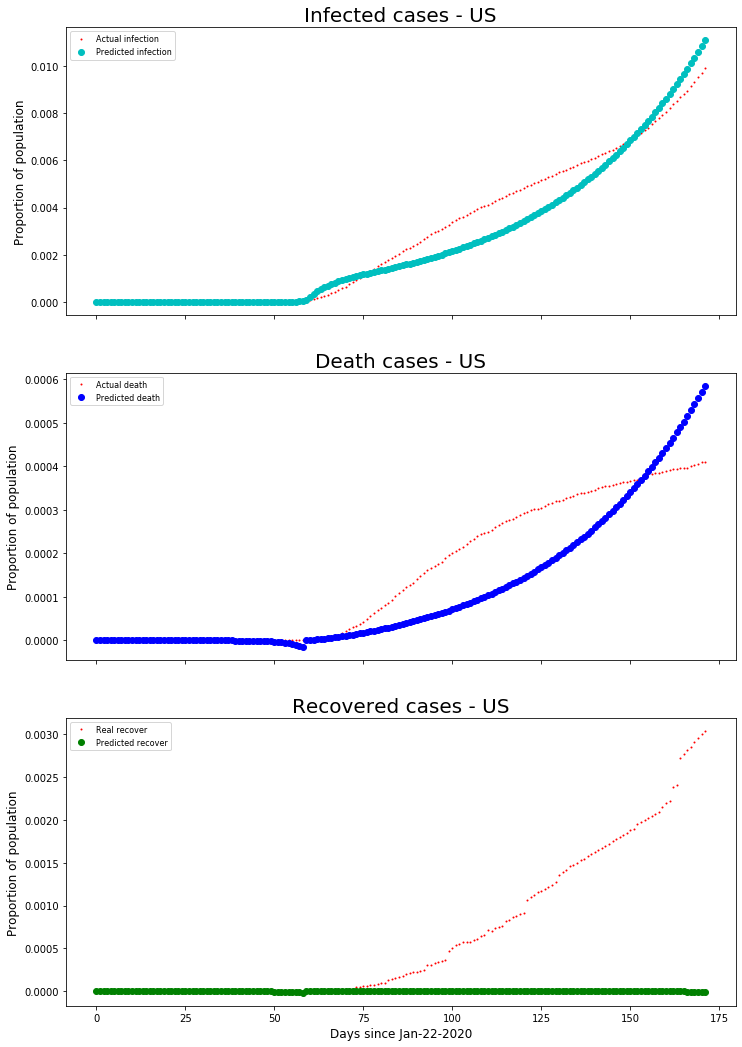

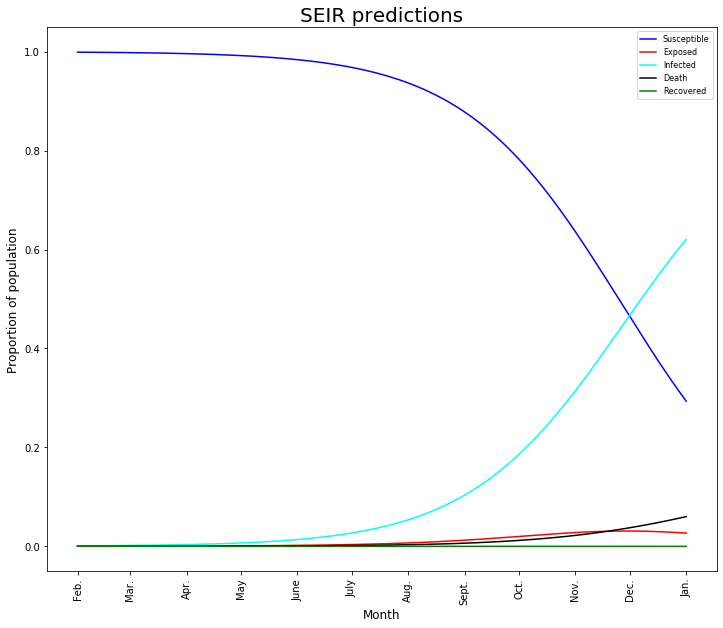

In [145]:
countryLockdown(328*1e6,us_status,58,'US')

# Italy

/Applications/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


## Italy before lockdown
Optimized infection rate:  0.13074103411824956
Optimized recovered rate:  -0.11551149765557299
Optimized exposed rate:  0.12294178036353673
Optimized death rate:  0.006085281181672517
Optimized reinfection rate:  3.5833615583212275


## Italy after lockdown
Optimize infection rate:  1.7805536955708676
Optimize recovered rate:  0.024067576706769574
Optimize exposed rate:  0.038876546767887224
Optimized death rate:  0.002646153862775745
Optimized reinfection rate:  0.019914238365627463
0.00016814115308151094
0.00016814115308151094


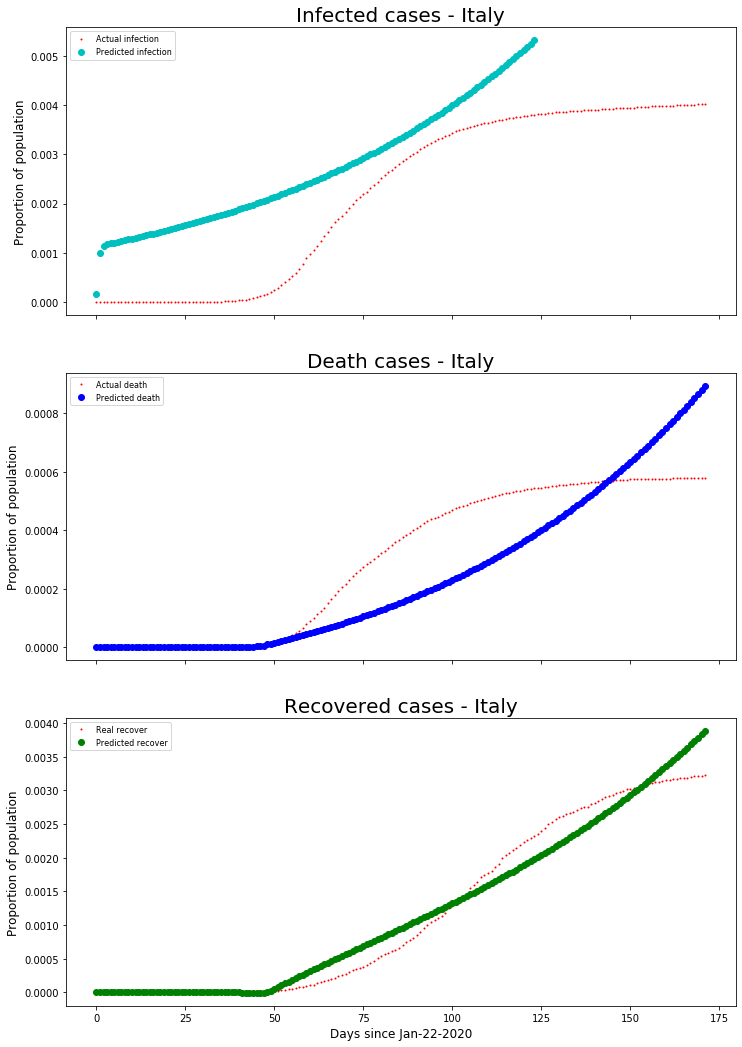

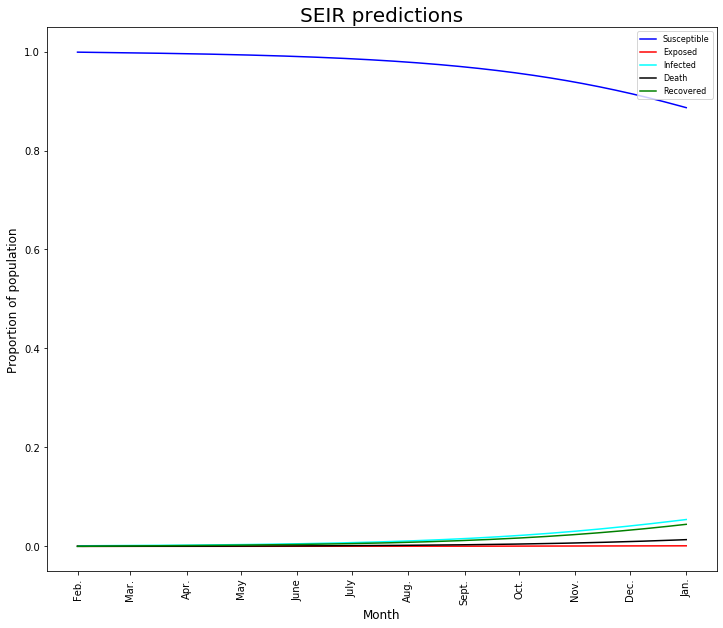

In [135]:
countryLockdown(60.36*1e6, itl_status,47,'Italy')

# France

In [ ]:
countryLockdown(66.99*1e6,frc_status,55,'France')


This model fits very well with the current data in US, Italy and France. According to its prediction, the proportion of infected people will reach the peak in around September, under the condition of lockdown. 
Generally, the percentage of death is around 5% (depending on the local hospital capacity and the number of screening tests). Thus, we hypothesized that 5% of infected population requires ICU care. Then we could predict that the amount of ICU requirement will increase until September, which is the predicted peak of infection.
